In [ ]:
# Author: Joshua Maldonado
# GitHub: https://github.com/Ub3rJosh
# Email: jm998521@ohio.edu (joshuamaldonado4432@gmail.com)

# Tutorial notebook that accompanies "Greedy Emulators for Nuclear Two-Body Scattering"

This notebook will walk one through the process from potential definitions to emulating across parameter spaces. 

All of this code is available on the GitHub repository: https://github.com/Ub3rJosh/greedy-emulators.

In [2]:
# imports
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("default")
import sys
sys.path.append("./modules/")

# plotting parameters
dpi = 150
plot_kwargs = {"color": "purple", "linewidth": 3, "alpha": 0.8}
title_size = 20
axes_size = 16

# handle random consistency
np.random.seed(12345)

# parameters for the coordinate-space
n = 1000
r, dr = np.linspace(0, 12, n, retstep=True)  # define coordinate-space mesh from 0fm to 12fm

# Brief walkthrough of the three major classes

<br>
<br>

## Nuclear Potentials (`Potential.py`)
There are two nuclear potentials implemented in this code, in the `Potential` class. 
These are the Minnesota potential, which is implemented and ready for use. And the GT+ $\chi$-EFT derived potential, formulated by [Gezerlis et al.](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.90.054323), which must be compiled to use, following the instructions laid out in `README.md` and the files in `chiral_construction/`. 
It is important that the potential has an affine structure (at least for the parameters that we would like to vary) for the sake of the emulator. 
In fact, we demand an affine structure for the construction of a Fast & Accurate emulator.
Techniques can be used to use a non-affine nuclear potential, such as the EIM (Empirical Interpolation Method).
This is true for the case of the parameters $V_R$ and $V_s$ in the Minnesota potential,
$$
\begin{gather}
    V(r, \theta) = V_R e^{- \kappa_R r^2} + V_s e^{- \kappa_s r^2} \, ,
\end{gather}
$$
or more generally,
$$
\begin{gather}
    V(r, \theta) = \sum_a^{n_\theta} \mathcal{V}_a(r) h_a(\theta) = \vec{\mathcal{V}}(r) \cdot \vec{h}(\theta) \,,
\end{gather}
$$
where $\mathcal{V}_a(r)$ is _parameter independent_ array, such as $e^{- \kappa_R r^2}$ (under the assumption that we do not want to vary $\kappa_R$) and $h_a(\theta)$ is smooth in $\theta$.

<br>

Note: I will take this opportunity to point out that  are the "bones" for implementing one's own affine nuclear potential into the form required by the solver and emulator in this code. This can be found in the `DoItYourselfPotential` class in `Potential.py`.



## Solver (`FOM.py`)
There are numerous numerical methods that can be used to solve our differential equation, the inhomogeneous radial Schrödinger equation (RSE),
$$
\begin{gather}
    \frac{d^2}{dr^2}\chi(r) = 
    \left(  
        \frac{\ell (\ell + 1)}{r^2} + 2 \mu V(r, \theta) - p^2
    \right) \chi(r)
    + 2 \mu  \, \zeta \, V(r, \theta) \phi(r) \,,
\end{gather}
$$
where $\mu$ is the reduced mass, $p^2 = 2 \mu E$, where $E$ is the center-of-mass energy, and $\phi(r)$ is the free solution.
The implementation for for full order model (FOM), or high-fidelity solver, this work to solve the RSE is the Matrix Numerov method.
The variable $\zeta$ works as a toggle between the _homogeneous_ ($\zeta=0$) and _inhomogeneous_ ($\zeta=1$) RSEs.

The RSE can be cast into a linear system, $A(\theta) y(\theta) = s(\theta)$ where
$$
\begin{align}
    A(\theta) &= \left( 
          \frac{d^2}{dr^2} + \frac{\ell (\ell + 1)}{r^2} + 2 \mu V(r, \theta) - p^2
        \right) \, ,
    \\
    y(\theta) &= \chi(r; \theta) \, ,
    \\
    s(\theta) &= 2 \mu \, \zeta \,V(r, \theta) \phi(r) \, .
\end{align}
$$

$\Big($ Note: $2 \mu \, \zeta \, V(r, \theta) \phi(r)$ can be replaced with $2 \mu \, \zeta \, V(r, \theta) F_\ell(r)$, and $\phi(r) = \frac{F_\ell(r)}{p}$. This will result in an amplitude difference, and factors of $p$ floating around in other equations.$\Big)$





## Emulator (`ROM.py`)
The two emulators, or reduced order models (ROMs) implemented for this work both use a Galerkin projections.
These emulators work by using a basis of snapshots, or solutions across the parameter space, and projecting them into a low-dimensional space.
These are the Galerkin reduced order model (G-ROM) which projects into the subspace of snapshots, and the Least-Squares Petrov-Galerkin reduced order model (LSPG-ROM) which projects into the subspace of residuals of the ODE.

Index notation will be used here, and each index corresponds to a particular space:
* $i$, $j$, $k$ ; The coordinate-space mesh indices, or FOM indices
* $u$, $v$ ; The reduced space indices, or (two of the) ROM indices
* $w$ ; The "semi-reduced" space index, or (the third) ROM index

The snapshot basis is a column-matrix made up of $n_b$ snapshots,
$$
\begin{gather}
    X = 
    \begin{bmatrix}
    | & | & & | & & | \\
    \chi_0 & \chi_1 & \cdots & \chi_u & \cdots & {\chi}_{n_b} \\ 
    | & | & & | & & | \\
    \end{bmatrix}\,.
\end{gather}
$$

### The **Galerkin Reduced Order Model** (G-ROM)
In the case of the G-ROM, the basis is then used to project the RSE's linear form $A y = s$,
$$
\begin{gather}
    \left( X^\dagger A(\theta) X \right) \vec{c}(\theta) = X^\dagger s(\theta) \, .
\end{gather}
$$
This system is then solved for a vector of coefficients $\vec{c}$, and used to _emulate_ the solution $y(r)$ by applying it to the snapshots,
$$
\begin{gather}
    \chi(r) \approx \tilde{\chi}(r) = X \cdot \vec{c}
\end{gather}
$$

If the potential $V(r, \theta)$ is affine in $\theta$ then we can re-write the above (in index notation now, as we'll be playing with tensors) as,
$$
\begin{gather}
    \left( \left[X^\dagger_{ui} A_{aij} X_{jv}) \right]_{auv} \theta_a \right)_{uv} c_{\,v} 
    = 
    \left( \left[ X^\dagger_{ui} s_{ai} \right]_{au} \theta_a \right)_{u} \, ,
\end{gather}
$$
where **_all_** of the quantities shown in square brackets, $[\dots]$, can be **_prestored_** to speed up the computation.

### The **Least-Squares Petrov-Galerkin Reduced Order Model** (LSPG-ROM)
The LSPG-ROM has highly similar equations to the G-ROM with the key difference that the left-projection will now be done with the matrix,
$$
\begin{gather}
    Y =
    \begin{bmatrix}
      B^{(0)} & B^{(1)} & \cdots & B^{(n_\theta)} & ; & s^{(0)} & s^{(1)} & \cdots & s^{(n_\theta)}
    \end{bmatrix} \, ,
\end{gather}
$$
where
$$
\begin{gather}
    B^{(a)} = \left( B^{(a)} \right)_{iu} = \left( A_{aji} X_{ju} \right)_{aiu} \\
    \rm{and} \\
    s^{(a)} = s_{aj} \, .
\end{gather}
$$
The matrix $Y$ _must_ be orthonormalized, as it acts as an orthogonal projector into the space of residuals of the differential equation. 
After orthonormalization, the matrix will be of size $Y_{wi}$. 
This results in the projection equation for the LSPG-ROM to be as follows,
$$
\begin{gather}
    \left( \left[Y^\dagger_{wi} A_{aij} X_{ju}) \right]_{awu} \theta_{a} \right)_{wu} c_u
    = 
    \left( \left[ Y^\dagger_{wi} s_{ai} \right]_{aw} \theta_{a} \right)_{w} \, ,
\end{gather}
$$
where **_all_** of the quantities shown in square brackets, $[\dots]$, can be **_prestored_** to speed up the computation, as before.


To define some terminology, the calculation of the snapshot basis $X$, and the reduced quantities in the square brackets take place in the "offline-stage" (or "training") of the emulator. 
The offline-stage of the emulator is done _once_. 
The application of $\theta$ onto the quantities found in previously calculated reduced quantities is called the "online-stage".
Thanks to the pre-calculation (and prestoring) of the reduced quantities, and thanks to the nuclear potential's affine structure, the online-stage of the emulator is computationally fast in comparison to the FOM.

## The Emulator Basis and The Greedy Algorithm
The role that $X$ plays in the emulator is critical, as the parameters that are in the emulator basis can make or break the efficacy of the emulator!
A natural question arises: 
> _How can I construct a good emulator basis?_

There is one common approach, to take many FOM calculations across the parameter space and apply a truncated SVD to the snapshots. 
From this, one can take the left-singular vectors from the SVD as the emulator basis. 
**This method requires _many_ FOM calculations, which may not always be feasible.**

An alternative approach that uses far fewer FOM calculations is to iteratively construct the basis using a **_greedy algorithm_**.
Such an approach has many benefits,
* Strict control over snapshot size
* Removal of singularities known as Kohn anomalies (if they are seen in the given parameter space)
* No thrown out FOM calculations
* Ability to specify desired emulator accuracy

<br>

![flowchart for the greedy algorithm](./markdown_figures/greedy_flowchart-modified.png)

<br>

<!-- As seen in step 1 of the flowchart, an error estimator is required for the greedy algorithm.
It is crucial that the error estimator is (nearly) _proportional_ to the exact error of the emulator, $\varepsilon_{\rm{exact}} = \chi - \tilde{\chi}$.
The error estimator (for the G-ROM) is based off of the residual of the ODE, $A(\theta) \chi - s(\theta)$, and is defined as,
$$
\begin{gather}
    \rm{\mathbf{r}}(\theta) = A(\theta) \tilde{\chi} - s(\theta)  % does the \bold{} call work in jupyter?
\end{gather}
$$
This can be expanded into $\rm{\mathbf{r}}^\dagger(\theta) \cdot \rm{\mathbf{r}}(\theta)$ and reduced into a quantity that has an efficient offline-online decomposition, just like the G-ROM and LSPG-ROM emulators.
This can be done by formulating the following:
$$
\begin{align*}
    \rm{\mathbf{r}}^2(\theta)
    = \,\,& 
    % \sqrt{\rm{\bold{r}}^\dagger(\theta) \cdot \rm{\bold{r}}(\theta)}
    % \\
    % = & (A(\theta) \tilde{\chi} - s(\theta))^\dagger \cdot (A(\theta) \tilde{\chi} - s(\theta))
    % \\
    % = & (\tilde{\chi}^\dagger A(\theta)^\dagger A(\theta) \tilde{\chi})
    % - (\tilde{\chi}^\dagger A(\theta)^\dagger s(\theta))
    % - (s(\theta)^\dagger  \tilde{\chi} A(\theta))
    % + (s(\theta)^\dagger s(\theta))
    % \\ & \vdots
    % \\
    % = \,\, & 
    \theta^\dagger_a c^\dagger_u 
    \left[
        X^\dagger_{ui} A^\dagger_{aik} A_{bkj} X_{vj}
    \right]_{abuv}
    \theta_b c_v 
    \\
    & - 2 \, \rm{Re} \left(
        \theta^\dagger_a c^\dagger_u 
        \left[
        X^\dagger_{ui} A^\dagger_{aij} s_{bj}
        \right]_{a b u}
        \theta_b
    \right)
    \\
    & + \theta^\dagger_a \left[
        s_{ai} s_{bi}
    \right]_{ab} \theta_b
\end{align*}
$$
where, again, the quantities in square brackets can and should be precalculated and stored for an efficient offline-online decomposition. -->

<br>
<br>
<br>

# Walkthrough using the Minnesota Potential

## Potential Initialization and Use
We must first call the `Potential` class from the modules. The initialization of this class will require the mesh for the problem, $r$, as well as the angular momentum quantum number, $\ell$.

For the GT+ local chiral potential, the final orbital angular momentum quantum number $\ell'$ (or `ll` in the code), total angular momentum quantum number $j$, and the spin quantum number of the system $S$.

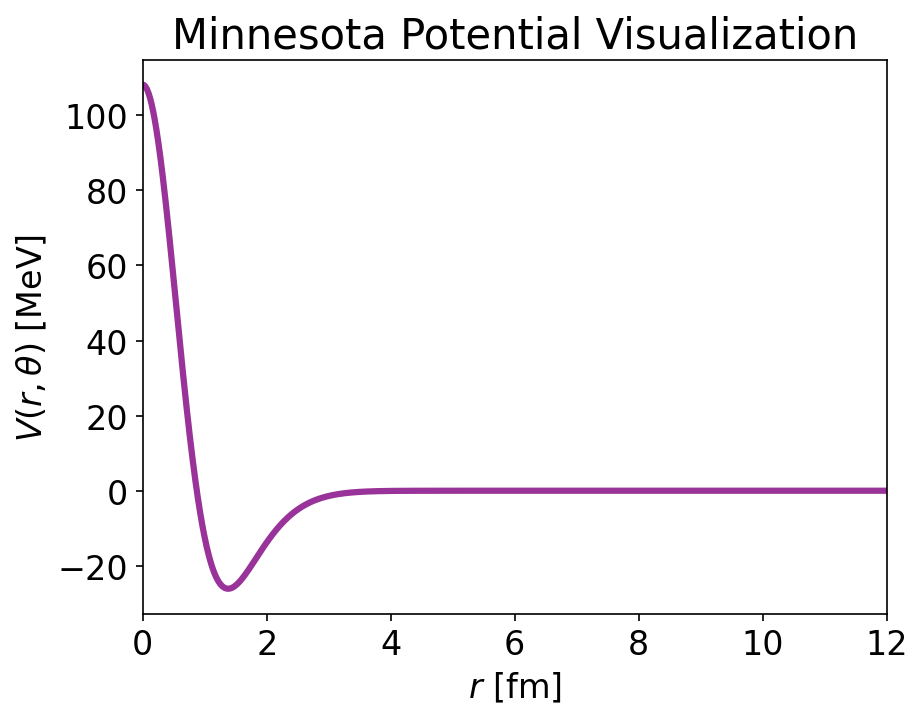

In [3]:
# import potential
from Potential import Potential


l = 0  # define angular momentum quantum number (this will be the 1S0 channel)
minnesota_potential = Potential("minnesota", r, l=l)  # define the potential class

# Let's visualize the potential
plt.figure(dpi=dpi)
plt.title("Minnesota Potential Visualization", fontsize=title_size)
plt.plot(r, minnesota_potential.potential_array(minnesota_potential.default_theta), **plot_kwargs)
plt.xlabel("$r$ [fm]", fontsize=axes_size)
plt.xticks(fontsize=axes_size)
plt.xlim(0, 12)
plt.ylabel(r"$V(r, \theta)$ [MeV]", fontsize=axes_size)
plt.yticks(fontsize=axes_size)
plt.show()

## Solver Initialization and Use

Now that we have a potential, we can initialize the solver. The solver used here is the Matrix Numerov solver, as implemented in `FOM.py`. This class will take in the potential as an argument and inherit some properties.

This solver can be used using $\zeta = 0, (1)$ for the (in)homogeneous RSE. This solver can also be used with or without simultaneously calculating the K matrix coefficients, $a$ and $b$, using the flag `use_ab`.

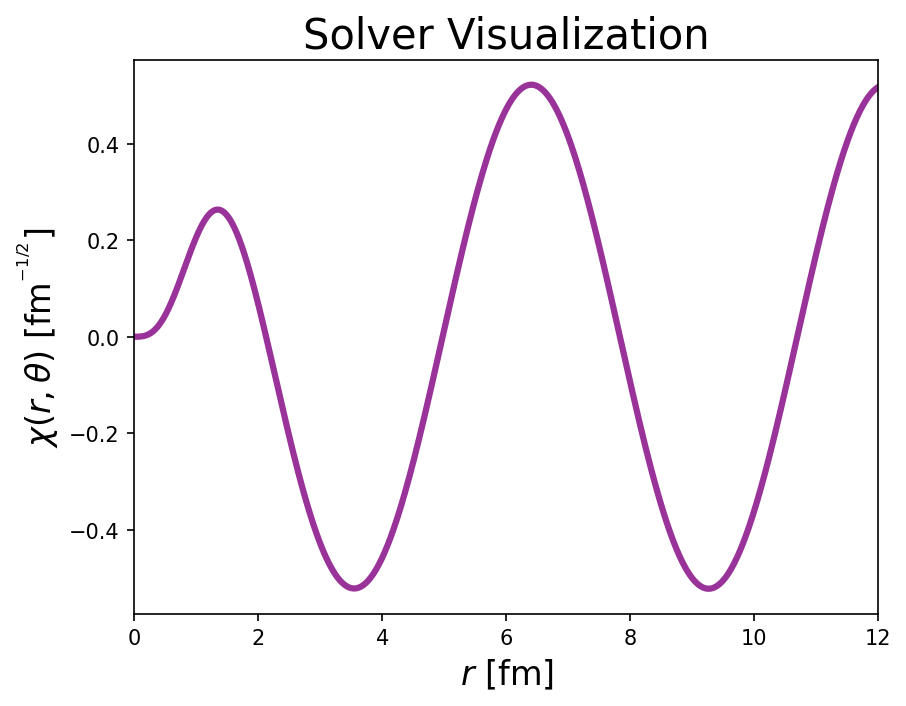

In [ ]:
# import the solver(s) implemented
from FOM import MatrixNumerovSolver


energy = 50  # MeV (center-of-mass energy)
minnesota_solver = MatrixNumerovSolver(minnesota_potential, energy=energy, zeta=1, use_ab=False)  # initialize the solver (zeta=1 <=> inhomogeneous RSE)


# Let's visualize the wavefunction
plt.figure(dpi=dpi)
plt.title("Solver Visualization", fontsize=title_size)
plt.plot(r, minnesota_solver.solve(), **plot_kwargs)
plt.xlabel("$r$ [fm]", fontsize=axes_size)
plt.xlim(0, 12)
plt.ylabel(r"$\chi(r, \theta)$ [fm$^{^{-1/2}}$]", fontsize=axes_size)
plt.show()

## Emulator Initialization and Use

Now that we have a potential and a solver defined, the emulator, or ROM, can be constructed. To do so, we need to define a parameter space that the emulator will "live" in. This may take some prior knowledge to meaningfully define. In the case of the Minnesota potential, we will first only vary one parameter, $-400 \rm{MeV} \le V_s \le 0 \rm{MeV}$. As with the `solver` class, the `Emulator` class will inherit some properties.

In [5]:
# import the emulator class
from ROM import Emulator

# define the parameter bounds
Vs_min = -400.
Vs_max = 0.
minnesota_parameter_bounds = {"V_s": [Vs_min, Vs_max]}  # define the parameter space as a dict that contains the boundaries of the space
# minnesota_parameter_bounds_2D_example = {"V_s": [Vs_min, Vs_max], "V_r": [Vr_min, Vr_max]}  # just an example. In non-1D cases, `sampling_method="LHS` is a good choice

# let's grab some random parameters to use as our snapshot basis
number_of_parameters = 4
snapshot_parameters = []
for i in np.arange(number_of_parameters):
    snapshot_parameter = (Vs_max - Vs_min) * np.random.random() + Vs_min  # map random number (0, 1) into range of bounds (Vs_min, Vs_max)
    snapshot_parameters.append({"V_s": snapshot_parameter})


# The emulator class will construct the basis using the given `snapshot_parameters` and apply the projections for the offline-online decomposition
minnesota_emulator = Emulator(minnesota_parameter_bounds,
                              minnesota_solver,
                              snapshot_max=number_of_parameters,
                              snapshot_parameters=snapshot_parameters,
                              emulation_method="G-ROM",  # (could be "LSPG-ROM")
                              error_estimation_method="G-ROM",  # (could be "LSPG-ROM")
                              sampling_method="linear",  # (could be "LHS", for LatinHypercube Sampling)
                              param_pts=400,  # one parameter point per MeV (could be changed)
                              greedy=False)

/Users/joshuamaldonado/Documents/GitHub/greedy-emulators/modules/gram_schmidt.py:79: NumbaPerformanceWarning: np.vdot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  orthogonal_matrix[:, k] -= np.vdot(orthonormal_matrix[:, j],


#### Let's take a look at how the emulated wave function compared to the full order model calculation

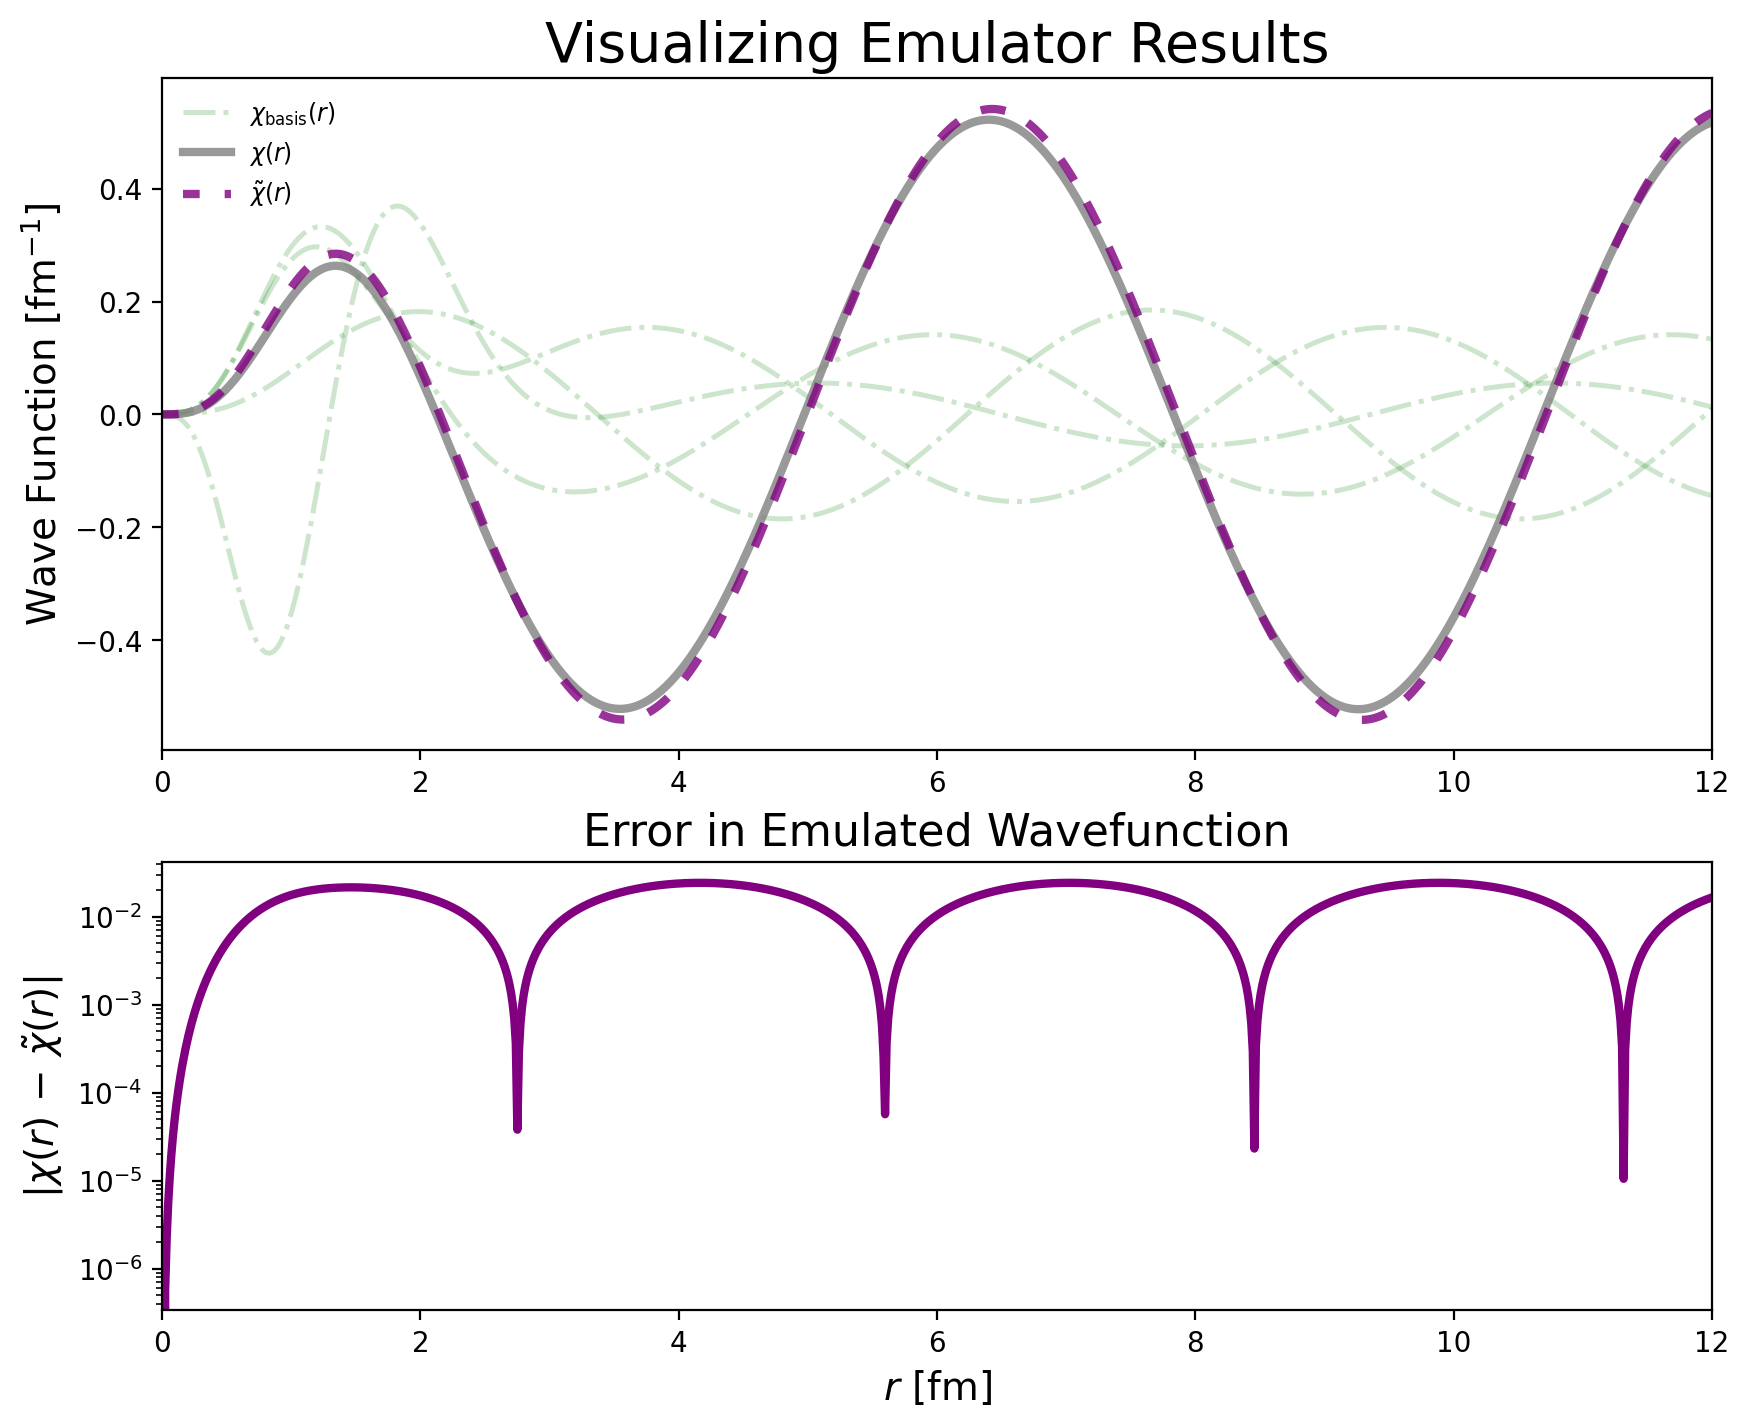

In [6]:
minnesota_theta = minnesota_potential.default_theta  # use the best-fit value in the parameter space

minnesota_emulator.emulation_errors_at_theta(minnesota_theta, basis_scaling=4, dpi=200)

#### Let's also take a look at the errors across the parameter space

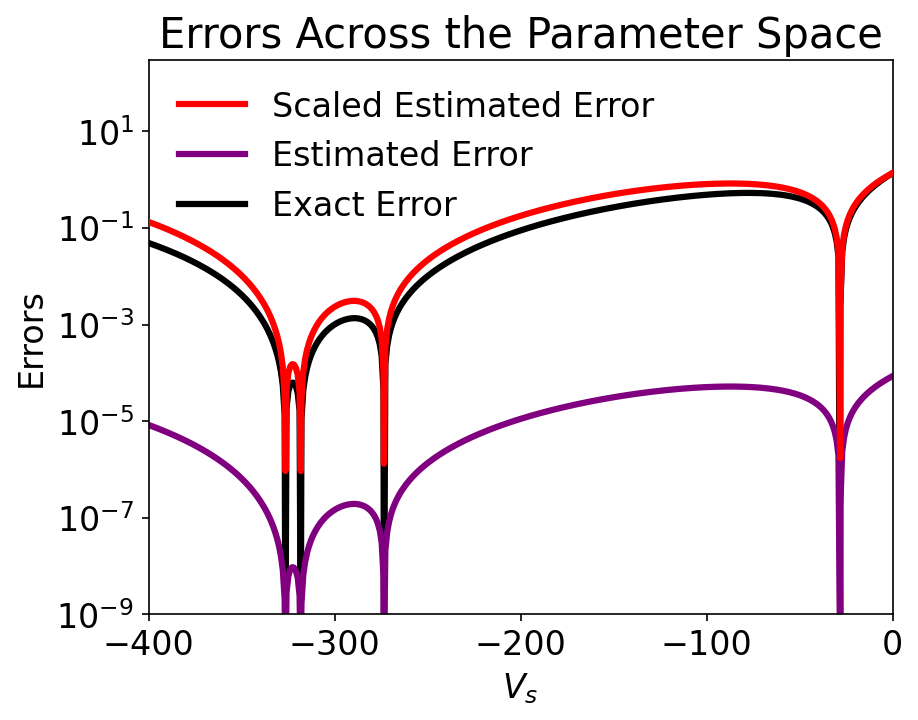

mean exact error = 0.193
mean scaled estimated error = 0.297


In [7]:
###   first we want to calculate the errors to plot them   ###

# initialize lists
exact_errors = []
estimated_errors = []

# loop through parameter space 
for i in np.arange(minnesota_emulator.param_pts):
    theta = minnesota_emulator.parameters_at_index(i)  # get the i-th index
    
    exact_chi = minnesota_solver.solve(theta)  # solve for the wave function
    emulated_chi, estimated_error = minnesota_emulator.emulate(theta, estimate_error=True)  # emulate wave function
    
    exact_error = np.linalg.norm(exact_chi - emulated_chi)  # calculate the exact error
    
    # store in lists
    exact_errors.append(exact_error)
    estimated_errors.append(estimated_error)
#

# scale estimated error such that the max value of exact error and scaled estimated error are the same
scaled_estimated_errors = np.asarray(estimated_errors) * (np.max(exact_errors) / np.max(estimated_errors))


# plotting time
parameter_space = minnesota_emulator.parameter_space["V_s"]

random_emulator_errors = plt.figure(dpi=dpi)
plt.title("Errors Across the Parameter Space", fontsize=title_size)

plt.plot(parameter_space, scaled_estimated_errors,
         color="red", linewidth=3, label="Scaled Estimated Error", zorder=3)
plt.plot(parameter_space, estimated_errors,
         color="purple", linewidth=3, label="Estimated Error", zorder=2)
plt.plot(parameter_space, exact_errors,
         color="black", linewidth=3, label="Exact Error", zorder=1)

plt.xlabel(r"$V_s$", fontsize=axes_size)
plt.xticks([-400, -300, -200, -100, 0], fontsize=axes_size)
plt.xlim(Vs_min, Vs_max)
plt.ylabel("Errors", fontsize=axes_size)
plt.yticks(fontsize=axes_size)
plt.ylim(1e-9, 3e2)
plt.yscale("log")

plt.legend(fontsize=axes_size, framealpha=0, loc="upper left")
plt.show()

print(f"mean exact error = {np.mean(exact_errors):.3}")
print(f"mean scaled estimated error = {np.mean(scaled_estimated_errors):.3}")

### Greedily Constructing a Basis

We can construct a basis in a greedy fashion, to calculate exactly as many FOM calculations as desired to construct the basis (+1 if we want access to the _scaled estimated error_).

In [8]:
# initialize new emulator class, using `greedy=True`
greedy_minnesota_emulator = Emulator(minnesota_parameter_bounds,
                                     minnesota_solver,
                                     snapshot_max=number_of_parameters,
                                     emulation_method="G-ROM",  # (could be "LSPG-ROM")
                                     error_estimation_method="G-ROM",  # (could be "LSPG-ROM")
                                     sampling_method="linear",  # (could be "LHS")
                                     param_pts=400,  # one parameter point per MeV
                                     greedy=True,
                                     use_scaled_estimated_error=True,
                                     ignore_error_bounds=True,  # save the time of calculating a ton of singular values
                                     verbose=False)

greedy_minnesota_emulator.train()  # construct basis using greedy algorithm and preform offline projections

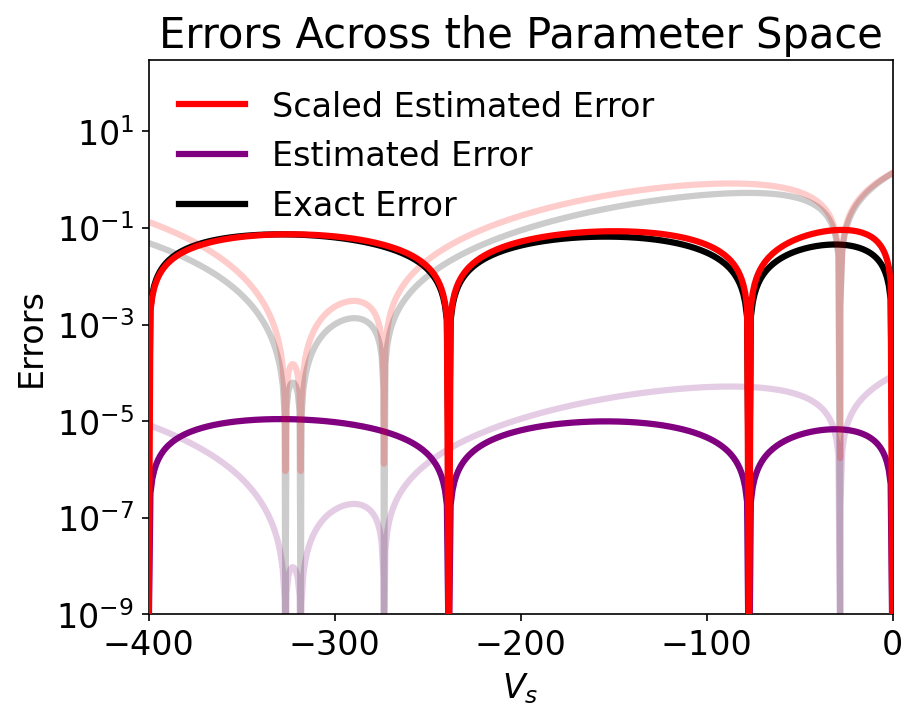



non-greedy basis results:
mean exact error = 1.930e-01
mean scaled estimated error = 2.975e-01

greedy basis results:
mean exact error = 5.254e-02
mean scaled estimated error = 4.192e-02


In [9]:
greedy_parameter_space = greedy_minnesota_emulator.parameter_space["V_s"]

# plotting time
random_emulator_errors = plt.figure(dpi=dpi)
plt.title("Errors Across the Parameter Space", fontsize=title_size)

plt.plot(greedy_parameter_space, greedy_minnesota_emulator.exact_errors[-1, :],
         color="red", linewidth=3, label="Scaled Estimated Error", zorder=3)
plt.plot(greedy_parameter_space, greedy_minnesota_emulator.estimated_errors[-1, :],
         color="purple", linewidth=3, label="Estimated Error", zorder=2)
plt.plot(greedy_parameter_space, greedy_minnesota_emulator.scaled_estimated_errors[-1, :],
         color="black", linewidth=3, label="Exact Error", zorder=1)

plt.plot(parameter_space, scaled_estimated_errors,
         alpha=0.2, color="red", linewidth=3, zorder=3)
plt.plot(parameter_space, estimated_errors,
         alpha=0.2, color="purple", linewidth=3, zorder=2)
plt.plot(parameter_space, exact_errors,
         alpha=0.2, color="black", linewidth=3, zorder=1)

plt.xlabel(r"$V_s$", fontsize=axes_size)
plt.xticks([-400, -300, -200, -100, 0], fontsize=axes_size)
plt.xlim(Vs_min, Vs_max)
plt.ylabel("Errors", fontsize=axes_size)
plt.yticks(fontsize=axes_size)
plt.ylim(1e-9, 3e2)
plt.yscale("log")

plt.legend(fontsize=axes_size, framealpha=0, loc="upper left")
plt.show()


print("\n\nnon-greedy basis results:")
print(f"mean exact error = {np.mean(exact_errors):.3e}")
print(f"mean scaled estimated error = {np.mean(scaled_estimated_errors):.3e}")
print("\ngreedy basis results:")
print(f"mean exact error = {np.mean(greedy_minnesota_emulator.exact_errors[-1, :]):.3e}")
print(f"mean scaled estimated error = {np.mean(greedy_minnesota_emulator.scaled_estimated_errors[-1, :]):.3e}")

<br>

### Comparing the Results

The greedy algorithm clearly has lower overall errors across the space. 
But, perhaps more importantly, the errors across the parameter space from the greedily constructed basis are far more consistent than the emulator using the randomly sampled basis.



### Quick look at speed ups

The emulator will always be less accurate than the full order model. In order for this to be worth it, the ROM had better be faster than the FOM. Is that the case here? Let's find out using `%timeit`:

In [10]:
print("     (Matrix Numerov) FOM runtime : ", end="")
FOM_runtime = %timeit -o -n 1000 minnesota_solver.solve(minnesota_theta)
print("                      ROM runtime : ", end="")
ROM_runtime = %timeit -o -n 1000 minnesota_emulator.emulate(minnesota_theta)
print("ROM with error estimation runtime : ", end="")
ROM_w_error_runtime = %timeit -o -n 1000 minnesota_emulator.emulate(minnesota_theta, estimate_error=True)


print("\nROM Speedup Factors")
print(f"without error estimation : {FOM_runtime.average / ROM_runtime.average:.2}x")
print(f"   with error estimation : {FOM_runtime.average / ROM_w_error_runtime.average:.2}x")

     (Matrix Numerov) FOM runtime : 89.5 μs ± 945 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
                      ROM runtime : 10.4 μs ± 151 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
ROM with error estimation runtime : 26.4 μs ± 3.67 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

ROM Speedup Factors
without error estimation : 8.6x
   with error estimation : 3.4x


In [11]:
# let's check solve_ivp's runtime, and see how the Matrix Numerov method performs.
from FOM_scipy import FOM as solve_ivp_FOM

r[0] = 1e-24  # numerical epsilon, since it can't handle r=0 in,  \ell * (\ell + 1) / r^2

tolerances = 1e-12
minnesota_solve_ivp = solve_ivp_FOM(r, l, potential_name="minnesota", atol=tolerances, rtol=tolerances)

print("Matrix Numerov runtime : ", end="")
print(FOM_runtime)
print("     solve_ivp runtime : ", end="")
%timeit -n 4 minnesota_solve_ivp.solve(minnesota_theta)

Matrix Numerov runtime : 89.5 μs ± 945 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
     solve_ivp runtime : 92.4 ms ± 799 μs per loop (mean ± std. dev. of 7 runs, 4 loops each)
